In [ ]:
pip install BoTorch

In [2]:
import os
import torch


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [3]:
from botorch.test_functions.multi_objective import BraninCurrin


problem = BraninCurrin(negate=True).to(**tkwargs)

In [4]:
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples

NOISE_SE = torch.tensor([15.19, 0.63], **tkwargs)

def generate_initial_data(n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds,n=n, q=1).squeeze(1)
    train_obj_true = problem(train_x)
    train_obj = train_obj_true + torch.randn_like(train_obj_true) * NOISE_SE
    return train_x, train_obj, train_obj_true


def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    train_x = normalize(train_x, problem.bounds)
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i:i+1]
        train_yvar = torch.full_like(train_y, NOISE_SE[i] ** 2)
        models.append(
            FixedNoiseGP(train_x, train_y, train_yvar, outcome_transform=Standardize(m=1))
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [5]:
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement, qNoisyExpectedHypervolumeImprovement
from botorch.utils.sampling import sample_simplex


BATCH_SIZE = 4
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

standard_bounds = torch.zeros(2, problem.dim, **tkwargs)
standard_bounds[1] = 1


def optimize_qehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    with torch.no_grad():
        pred = model.posterior(normalize(train_x, problem.bounds)).mean
    partitioning = FastNondominatedPartitioning(
        ref_point=problem.ref_point, 
        Y=pred,
    )
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point,
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

In [6]:
def optimize_qnehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point.tolist(),  # use known reference point 
        X_baseline=normalize(train_x, problem.bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

In [7]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement


def optimize_qnparego_and_get_observation(model, train_x, train_obj, sampler):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization 
    of the qNParEGO acquisition function, and returns a new candidate and observation."""
    train_x = normalize(train_x, problem.bounds)
    with torch.no_grad():
        pred = model.posterior(train_x).mean
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        weights = sample_simplex(problem.num_objectives, **tkwargs).squeeze()
        objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=pred))
        acq_func = qNoisyExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            X_baseline=train_x,
            sampler=sampler,
            prune_baseline=True,
        )
        acq_func_list.append(acq_func)
    # optimize
    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=standard_bounds,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

In [8]:
from botorch import fit_gpytorch_model
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning

import time
import warnings


warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

N_BATCH = 20 if not SMOKE_TEST else 10
MC_SAMPLES = 128  if not SMOKE_TEST else 16

verbose = True

hvs_qparego, hvs_qehvi, hvs_qnehvi, hvs_random = [], [], [], []

# call helper functions to generate initial training data and initialize model
train_x_qparego, train_obj_qparego, train_obj_true_qparego = generate_initial_data(n=2*(problem.dim+1))
mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)

train_x_qehvi, train_obj_qehvi, train_obj_true_qehvi = train_x_qparego, train_obj_qparego, train_obj_true_qparego
train_x_qnehvi, train_obj_qnehvi, train_obj_true_qnehvi = train_x_qparego, train_obj_qparego, train_obj_true_qparego
train_x_random, train_obj_random, train_obj_true_random = train_x_qparego, train_obj_qparego, train_obj_true_qparego
mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)
mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi)

# compute hypervolume
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qparego)
volume = bd.compute_hypervolume().item()

hvs_qparego.append(volume)
hvs_qehvi.append(volume)
hvs_qnehvi.append(volume)
hvs_random.append(volume)

# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(1, N_BATCH + 1):    
    
    t0 = time.time()
    
    # fit the models
    fit_gpytorch_model(mll_qparego)
    fit_gpytorch_model(mll_qehvi)
    fit_gpytorch_model(mll_qnehvi)
    
    # define the qEI and qNEI acquisition modules using a QMC sampler
    qparego_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
    qehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
    qnehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
    
    # optimize acquisition functions and get new observations
    new_x_qparego, new_obj_qparego, new_obj_true_qparego = optimize_qnparego_and_get_observation(
        model_qparego, train_x_qparego, train_obj_qparego, qparego_sampler
    )
    new_x_qehvi, new_obj_qehvi, new_obj_true_qehvi = optimize_qehvi_and_get_observation(
        model_qehvi, train_x_qehvi, train_obj_qehvi, qehvi_sampler
    )
    new_x_qnehvi, new_obj_qnehvi, new_obj_true_qnehvi = optimize_qnehvi_and_get_observation(
        model_qnehvi, train_x_qnehvi, train_obj_qnehvi, qnehvi_sampler
    )
    new_x_random, new_obj_random, new_obj_true_random = generate_initial_data(n=BATCH_SIZE)
            
    # update training points
    train_x_qparego = torch.cat([train_x_qparego, new_x_qparego])
    train_obj_qparego = torch.cat([train_obj_qparego, new_obj_qparego])
    train_obj_true_qparego = torch.cat([train_obj_true_qparego, new_obj_true_qparego])

    train_x_qehvi = torch.cat([train_x_qehvi, new_x_qehvi])
    train_obj_qehvi = torch.cat([train_obj_qehvi, new_obj_qehvi])
    train_obj_true_qehvi = torch.cat([train_obj_true_qehvi, new_obj_true_qehvi])
    
    train_x_qnehvi = torch.cat([train_x_qnehvi, new_x_qnehvi])
    train_obj_qnehvi = torch.cat([train_obj_qnehvi, new_obj_qnehvi])
    train_obj_true_qnehvi = torch.cat([train_obj_true_qnehvi, new_obj_true_qnehvi])

    train_x_random = torch.cat([train_x_random, new_x_random])
    train_obj_random = torch.cat([train_obj_random, new_obj_random])
    train_obj_true_random = torch.cat([train_obj_true_random, new_obj_true_random])
    

    # update progress
    for hvs_list, train_obj in zip(
        (hvs_random, hvs_qparego, hvs_qehvi, hvs_qnehvi), 
        (train_obj_true_random, train_obj_true_qparego, train_obj_true_qehvi, train_obj_true_qnehvi),
    ):
        # compute hypervolume
        bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj)
        volume = bd.compute_hypervolume().item()
        hvs_list.append(volume)

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)
    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)
    mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi)
    
    t1 = time.time()
    
    if verbose:
        print(
            f"\nBatch {iteration:>2}: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = "
            f"({hvs_random[-1]:>4.2f}, {hvs_qparego[-1]:>4.2f}, {hvs_qehvi[-1]:>4.2f}, {hvs_qnehvi[-1]:>4.2f}), "
            f"time = {t1-t0:>4.2f}.", end=""
        )
    else:
        print(".", end="")

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution



Batch  1: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (0.00, 0.00, 23.66, 35.43), time = 20.01.
Batch  2: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (0.00, 2.37, 25.21, 38.53), time = 22.89.
Batch  3: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (0.00, 26.22, 31.32, 44.16), time = 24.69.
Batch  4: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (0.00, 26.22, 38.35, 49.97), time = 27.71.
Batch  5: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (0.00, 38.07, 44.02, 51.19), time = 28.16.
Batch  6: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (16.55, 47.72, 45.50, 53.98), time = 25.92.
Batch  7: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (16.55, 50.77, 45.87, 54.64), time = 26.13.
Batch  8: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (16.55, 50.77, 46.13, 55.20), time = 30.49.
Batch  9: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (16.55, 50.77, 47.06, 55.87), time = 33.71.
Batch 10: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (16.55, 50.77, 47.84, 56.54), 

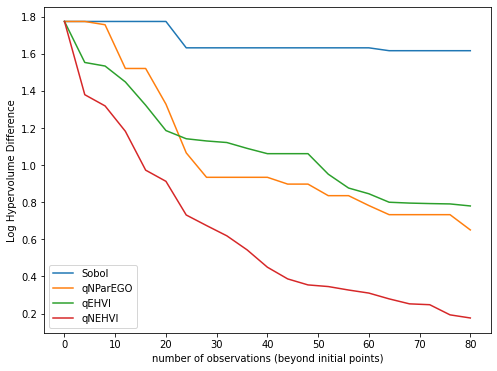

In [9]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
log_hv_difference_qparego = np.log10(problem.max_hv - np.asarray(hvs_qparego))
log_hv_difference_qehvi = np.log10(problem.max_hv - np.asarray(hvs_qehvi))
log_hv_difference_qnehvi = np.log10(problem.max_hv - np.asarray(hvs_qnehvi))
log_hv_difference_rnd = np.log10(problem.max_hv - np.asarray(hvs_random))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(
    iters, log_hv_difference_rnd, label="Sobol", linewidth=1.5,
)
ax.errorbar(
    iters, log_hv_difference_qparego, label="qNParEGO", linewidth=1.5,
)
ax.errorbar(
    iters, log_hv_difference_qehvi, label="qEHVI", linewidth=1.5,
)
ax.errorbar(
    iters, log_hv_difference_qnehvi, label="qNEHVI", linewidth=1.5,
)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='Log Hypervolume Difference')
ax.legend(loc="lower left")

Text(0.5, 1.0, 'Iteration')

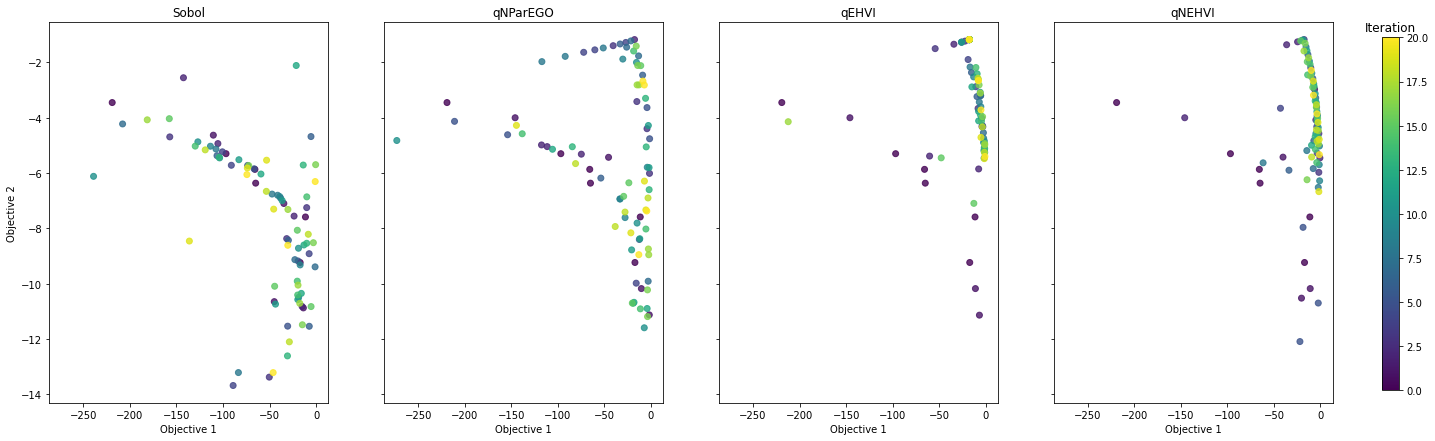

In [10]:
from matplotlib.cm import ScalarMappable


fig, axes = plt.subplots(1, 4, figsize=(23, 7), sharex=True, sharey=True)
algos = ["Sobol", "qNParEGO", "qEHVI", "qNEHVI"]
cm = plt.cm.get_cmap('viridis')

batch_number = torch.cat(
    [torch.zeros(2*(problem.dim+1)), torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()
for i, train_obj in enumerate((train_obj_true_random, train_obj_true_qparego, train_obj_true_qehvi, train_obj_true_qnehvi)):
    sc = axes[i].scatter(
        train_obj[:, 0].cpu().numpy(), train_obj[:,1].cpu().numpy(), c=batch_number, alpha=0.8,
    )
    axes[i].set_title(algos[i])
    axes[i].set_xlabel("Objective 1")
axes[0].set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")